# Passbands Tutorial
This tutorial shows how to create and use passband objects, which can be

- [Tabulated files](#tabulated-passbands)
- [Top-hat functions](#tophat-passbands)

Then the [Observation Files](#observation-files) section shows how to handle sets of passbands.

<div class="alert alert-info">

Note

You can also find this tutorial as a [Python script here](https://github.com/pcubillos/pyratbay/blob/master/docs/cookbooks/passbands.py) or as a [jupyter notebook here](https://github.com/pcubillos/pyratbay/blob/master/docs/cookbooks/passbands.ipynb).

</div>

## Passband Objects

``pyrat bay`` can process bandpass filters in two ways, from tabulated files (typically intended for broadband photometric filters) or from top-hat functions (typically intended when splitting narrow spectral bands into narrow bins). 

### Tabulated Passbands

Tabulated passband files are plain-text files with two columns, the wavelength (in micron units) and the response function (in units of electron per incoming photon).  Users can specify their own pass band files or use one of the passband files included in ``pyrat bay`` provides a few of them for commonly used instruments (see example below to access these files).

| Pass band | Central wavelength (um) | File name|
| --- | :---: | --- |
| CHEOPS        | 0.64 | cheops.dat |
| Kepler        | 0.64 | kepler.dat |
| TESS          | 0.80 | tess.dat |
| Spitzer/IRAC1 | 3.6  | spitzer_irac1.dat |
| Spitzer/IRAC2 | 4.5  | spitzer_irac2.dat |
| Spitzer/IRAC3 | 5.6  | spitzer_irac3.dat |
| Spitzer/IRAC4 | 8.0  | spitzer_irac4.dat |
| Spitzer/MIPS  | 24.0 | spitzer_mips.dat |

Here's an example using Spitzer passbands for a blackbody spectrum (note that `pc.FILTERS` is a constant pointing to the folder containing the filters listed above):

(0.5, 6.0)

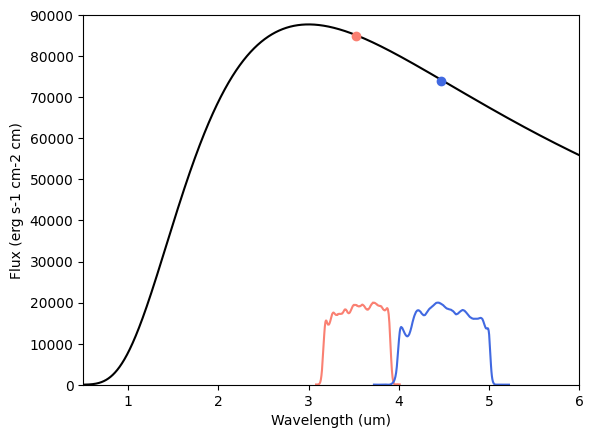

In [1]:
import pyratbay.spectrum as ps
import pyratbay.constants as pc
import matplotlib.pyplot as plt
import numpy as np


# A blackbody spectrum
wl = ps.constant_resolution_spectrum(0.5, 6.0, resolution=1000.0)
bb_spectrum = ps.bbflux(wn=1/(wl*pc.um), teff=1700.0)

# Initialize passbands (and sample over the wl sampling of the spectrum)
irac1 = ps.PassBand(f'{pc.FILTERS}/spitzer_irac1.dat', wl=wl)
irac2 = ps.PassBand(f'{pc.FILTERS}/spitzer_irac2.dat', wl=wl)

# Integrate spectrum over passbands
spitzer_fluxes = [
    irac1.integrate(bb_spectrum),
    irac2.integrate(bb_spectrum),
]

plt.figure(0)
plt.clf()
plt.plot(wl, bb_spectrum, c='k')
plt.plot(irac1.wl0, spitzer_fluxes[0], 'o', c='salmon')
plt.plot(irac2.wl0, spitzer_fluxes[1], 'o', c='royalblue')
plt.plot(irac1.wl, irac1.response*2e4, c='salmon')
plt.plot(irac2.wl, irac2.response*2e4, c='royalblue')
plt.xlabel('Wavelength (um)')
plt.ylabel('Flux (erg s-1 cm-2 cm)')
plt.ylim(0, 90000)
plt.xlim(0.5, 6.0)


<div class="alert alert-info">

Note

Note that the passbands response functions $S(\lambda)$ are by default assumed to count photons, and thus the `integrate()` method calculates the band-integrated value of a spectral function $f(\lambda)$ value as:

$$   F_{\rm band} = \frac{\int f(\lambda) S(\lambda) \lambda {\rm d}\lambda}{\int S(\lambda) \lambda {\rm d}\lambda} $$

Users can specify that the input response function is countung energy with the following argument at initialization: `band = ps.PassBand(filter_file, counting_type='energy')`, in which case the `integrate()` method computes:

$$   F = \frac{\int f(\lambda) S(\lambda) {\rm d}\lambda}{\int S(\lambda) {\rm d}\lambda} $$

This normally does not make much difference, except when dealing with broad photometric bands (e.g., Kepler, CHEOPS, or TESS).

</div>

### Tophat Passbands

Altenatively, when one works with spectroscopic data, it is usually desired to split the data into a set of bins modeled as top-hat passbands.

(0.5, 6.0)

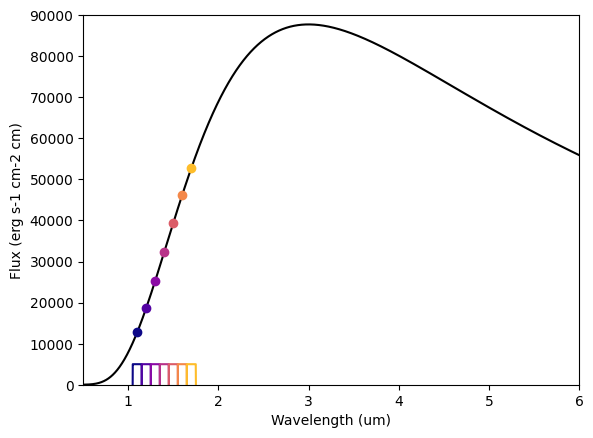

In [3]:
# A blackbody spectrum
wl = ps.constant_resolution_spectrum(0.5, 6.0, resolution=1000.0)
bb_spectrum = ps.bbflux(wn=1/(wl*pc.um), teff=1700.0)


# Top-hat passband objects can be created by setting
# their central wavelength and half-width (in micron units):
half_width = 0.05
central_wavelengths = np.arange(1.1, 1.8, 2*half_width)
hst_bands = [ps.Tophat(wl0, half_width, wl=wl) for wl0 in central_wavelengths]

# Integrate spectrum over passbands
hst_fluxes = [band.integrate(bb_spectrum) for band in hst_bands]

plt.figure(0)
plt.clf()
plt.plot(wl, bb_spectrum, c='k')
for i,band in enumerate(hst_bands):
    color = plt.cm.plasma(i/7)
    plt.plot(band.wl0, hst_fluxes[i], 'o', c=color)
    plt.plot(band.wl, band.response*5000, c=color)
    plt.xlabel('Wavelength (um)')
plt.ylabel('Flux (erg s-1 cm-2 cm)')
plt.ylim(0,90000)
plt.xlim(0.5, 6.0)

## Observation Files
If you have a set of observations for a given target, you can generate the filters for these data by loading the info from a file like the one below (note how you can combine top-hat and broadband filters):

```bash
# observations.dat file

# Passband info could be (1) a path to a file or (2) a tophat filter
# defined by a central wavelength, half-width, and optionally a name.
# Central-wavelength and half-width units are always microns

# @DEPTH_UNITS sets the depth and uncert units (none, percent, ppt, ppm)
# and also indicates that there's data and uncerts to read
# as two columns before the passband info
@DEPTH_UNITS
ppm

@DATA
# depth uncert  wavelength  half_width  passband_name
# depth uncert  passband_file
    107    82   1.100       0.050       hws_wfc3
    162    83   1.200       0.050       hws_wfc3
    207    82   1.300       0.050       hws_wfc3
    310    97   1.400       0.050       hws_wfc3
    382   101   1.500       0.050       hws_wfc3
    366   107   1.600       0.050       hws_wfc3
    497   116   1.700       0.050       hws_wfc3
   1118    84   {FILTERS}spitzer_irac1.dat
   1465    92   {FILTERS}spitzer_irac2.dat
```

Note that the `{FILTERS}` text works as a path to the filters provided by ``pyrat bay``.

Now, say that these observations correspond to a set of eclipse-depth observations.  The example below shows how to load this file into passbands, and then simulate some spectra to compare band-integrated models and data.

Text(0, 0.5, 'Eclipse depth (ppm)')

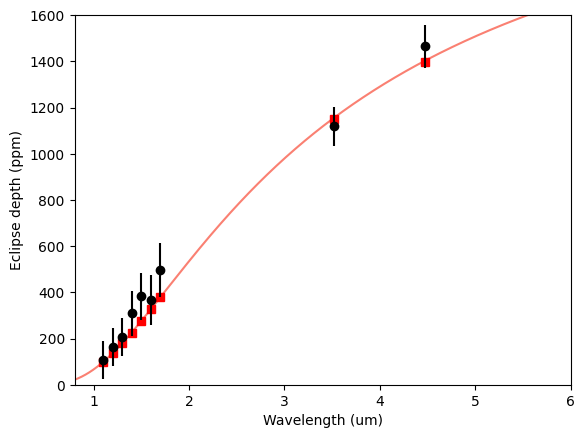

In [4]:
import pyratbay.io as io

# Say, I have a planet and star with these properties:
tstar = 6700.0
tplanet = 2100.0
rprs = 1.60 * pc.rjup / (1.81 * pc.rsun)


# Load passbands and observations info:
bands, depths, uncerts = io.read_observations('observations.dat')
band_wl = [band.wl0 for band in bands]
# Evaluate passbands at given spectral array:
wl = ps.constant_resolution_spectrum(0.5, 6.0, resolution=1000.0)
for band in bands:
    band.set_sampling(wl=wl)


# Compute the planet-to-star flux ratios
bb_star = ps.bbflux(wn=1/(wl*pc.um), teff=tstar)
bandflux_star = np.array([band.integrate(bb_star) for band in bands])

bb_spectrum = ps.bbflux(wn=1/(wl*pc.um), teff=tplanet)
bandflux = np.array([band.integrate(bb_spectrum) for band in bands])

flux_ratio = bandflux / bandflux_star * rprs**2.0
model = bb_spectrum/bb_star * rprs**2


plt.figure(10)
plt.clf()
plt.plot(wl, model/pc.ppm, color='salmon')
plt.plot(band_wl, flux_ratio/pc.ppm, 's', color='red')
plt.errorbar(band_wl, depths/pc.ppm, uncerts/pc.ppm, fmt='ok')
plt.ylim(0, 1600)
plt.xlim(0.8, 6.0)
plt.xlabel('Wavelength (um)')
plt.ylabel('Eclipse depth (ppm)')